# Models utilitzant només les variables meteorològiques i de contaminació

In [12]:
import pandas as pd
import numpy as np

In [26]:
import pandas as pd

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_no_deleted.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_no_deleted.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train_perf_no_del.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test_perf_no_del.csv")

The variable to predict, instead of performance, is going to be the percentage respect to that person's maximum performance. This way, we can really use the "environmental" variables and we try to avoid factors such as age, district...

In [27]:
train_df = pd.concat([X_train_std, y_train], axis=1)

train_max_performances = train_df.groupby('ID_Zenodo')['performance'].max()
train_df = train_df.merge(train_max_performances, left_on='ID_Zenodo', right_index=True, suffixes=('', '_max'))


min_performance = train_df['performance'].min()
train_df['y_percentage'] = (train_df['performance'] - min_performance) / (train_df['performance_max'] - min_performance)
train_df.drop(columns=['performance_max'], inplace=True)

# Same for test
test_df = pd.concat([X_test_std, y_test], axis=1)
test_df = test_df.merge(train_max_performances, left_on='ID_Zenodo', right_index=True, suffixes=('', '_max'))
#min_performance = test_df['z_performance'].min() # nose si això està be??
test_df['y_percentage'] = (test_df['performance'] - min_performance) / (test_df['performance_max'] - min_performance)

test_df.drop(columns=['performance_max'], inplace=True)

test_df['y_percentage'] = test_df['y_percentage'].clip(0, 1) #If you want to avoid values bigger than 1?


In [28]:
y_train = np.ravel(train_df["y_percentage"])
y_test = np.ravel(test_df["y_percentage"])

In [30]:
X_train_std.columns

Index(['index', 'ID_Zenodo', 'dayoftheweek', 'bienestar', 'energia', 'estres',
       'sueno', 'occurrence_stroop', 'no2bcn_24h', 'no2bcn_12h', 'no2gps_24h',
       'no2gps_12h', 'no2bcn_12h_x30', 'no2bcn_24h_x30', 'no2gps_12h_x30',
       'no2gps_24h_x30', 'pm25bcn', 'BCμg', 'tmean_24h', 'tmean_12h',
       'humi_24h', 'humi_12h', 'pressure_24h', 'pressure_12h', 'precip_24h',
       'precip_12h', 'maxwindspeed_24h', 'maxwindspeed_12h', 'age_yrs',
       'actividadfisica_Yes', 'ordenador_Yes', 'dieta_Yes', 'alcohol_Yes',
       'drogas_Yes', 'bebida_Yes', 'enfermo_Yes', 'otrofactor_Yes',
       'precip_12h_binary_1', 'precip_24h_binary_1', 'noise_total_LDEN_55_1.0',
       'access_greenbluespaces_300mbuff_Yes',
       'incidence_cat_Mobility incidence', 'incidence_cat_No incidence',
       'incidence_cat_Physical and Mobility incidences',
       'incidence_cat_Physical incidence', 'smoke_Yes', 'psycho_Yes',
       'gender_Hombre', 'gender_Mujer', 'gender_Otra', 'district_16',
       'd

In [31]:
pollutionMeteo_columns = ['no2bcn_24h', 'no2bcn_12h', 'no2gps_24h',
       'no2gps_12h', 'pm25bcn', 'BCμg', 'tmean_24h', 'tmean_12h', 'humi_24h',
       'humi_12h', 'pressure_24h', 'pressure_12h', 'precip_24h', 'precip_12h',
       'maxwindspeed_24h', 'maxwindspeed_12h','precip_12h_binary_1', 'noise_total_LDEN_55_1.0', 'occurrence_stroop',
       'access_greenbluespaces_300mbuff_Yes']

X_train_std = X_train_std[pollutionMeteo_columns]
X_test_std = X_test_std[pollutionMeteo_columns]


## Model de regressió lineal

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=5, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

In [33]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.10796026054929009
R2 val: 0.08859710902255116
R2 test: 0.11229741007173011


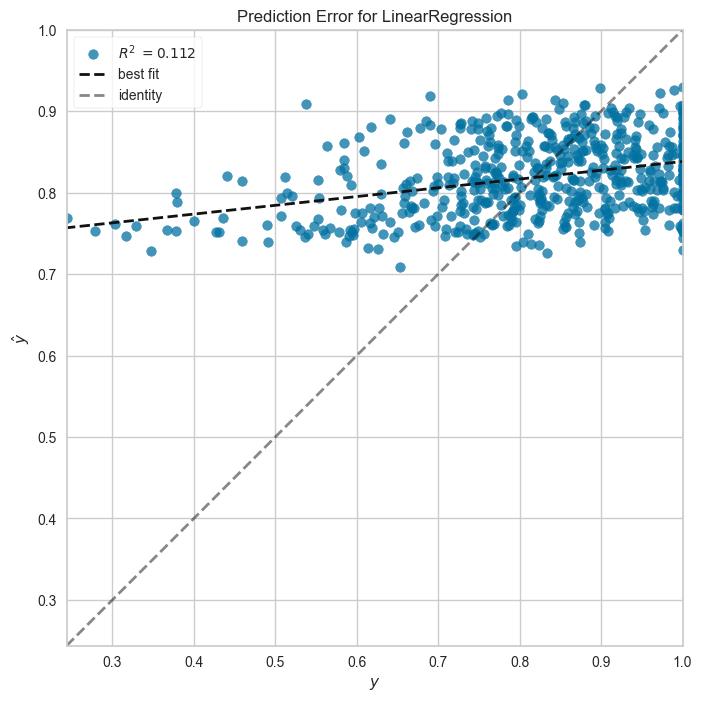

In [34]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [35]:
from sklearn.model_selection import cross_val_score
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alpha, scoring="r2", cv=5).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV(alphas=alpha, scoring="r2", cv=5), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Validation R2: ", ridge_r2_val2)

print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.10696764207467502
Validation R2:  0.09274813465961221
Validation R2:  0.09274813465961221
Test R2:  0.11085486965221003
100.0


### Lasso Regression

In [36]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, alphas=alpha).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(alphas=alpha, random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.09680076815201677
Validation R2:  0.09705134841202501
Test R2:  0.09712088130495167
0.01


In [37]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train,}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results


[0.08859710902255116, 0.09274813465961221, 0.09705134841202501]


,LR,Ridge,Lasso
Train R2,0.107960,0.106968,0.096801
CV (Val) R2,0.088597,0.092748,0.097051
Test R2,0.112297,0.110855,0.097121
lambda,0.000000,100.000000,0.010000


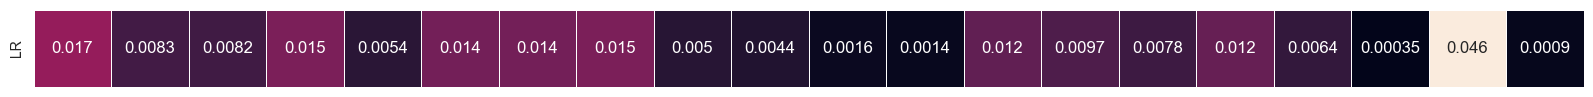

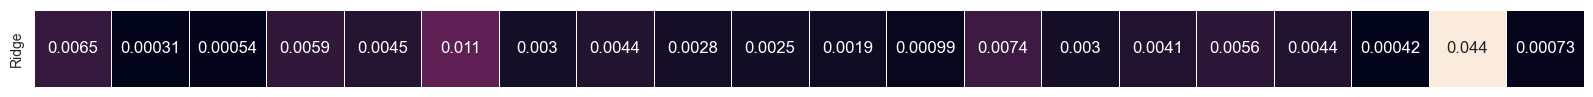

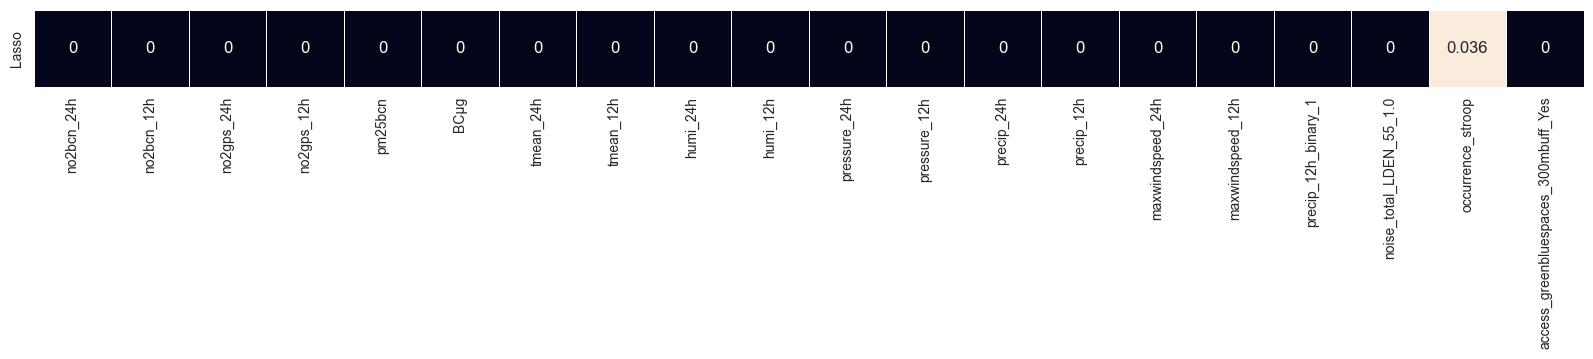

In [38]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

# MLP

In [39]:
X_train_std_old = X_train_std.copy()
X_test_std_old = X_test_std.copy()

In [40]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist

from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, fetch_covtype, fetch_california_housing
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_std.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 2000
batch_size = 256
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))



Epoch 1/2000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7924 - mean_squared_error: 0.4965 - val_loss: 3.2496 - val_mean_squared_error: 0.1308
Epoch 2/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1299 - mean_squared_error: 0.0808 - val_loss: 2.8845 - val_mean_squared_error: 0.0615
Epoch 3/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8102 - mean_squared_error: 0.0582 - val_loss: 2.5703 - val_mean_squared_error: 0.0401
Epoch 4/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5017 - mean_squared_error: 0.0397 - val_loss: 2.2849 - val_mean_squared_error: 0.0367
Epoch 5/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2175 - mean_squared_error: 0.0335 - val_loss: 2.0231 - val_mean_squared_error: 0.0361
Epoch 6/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9583 - mean_squared_error: 0.0292 - val_loss: 1.7840 - val_mean_squared_error: 0.0330
Epoch 7/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7255 - mean_squared_error: 0.0271 - val_loss: 1.5686 - val_mean_squared_erro

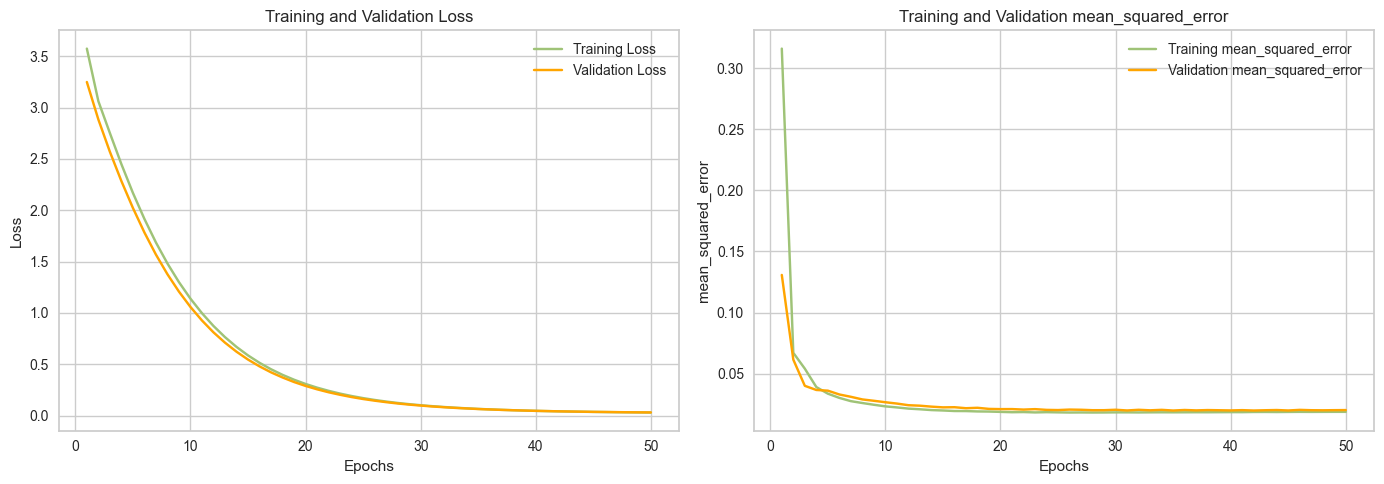

In [41]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()

plot_curves(history)

In [83]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800,), random_state=1, max_iter=500).fit(X_train_std, y_train)
regr.score(X_test_std, y_test)

-0.0958497093328261